<a href="https://colab.research.google.com/github/khanabdulmajid/tensorflow_deep_learning/blob/main/Transfer_learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-09-14 07:22:31.379819


In [ ]:
# Note: Issues with TensorFlow 2.10+, however, TensorFlow 2.9 seems to work better
# This may be fixed in the future.
# see: https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0s
# and here: https://github.com/keras-team/keras/issues/16983

# Install TensorFlow 2.9.0 ("-U" stands for "update", "-q" stands for "quiet")
# !pip install -U -q tensorflow==2.9.0

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.13.0


In [ ]:
# Are we using a GPU? (if not & you're using Google Colab, go to Runtime -> Change Runtime Type -> Harware Accelerator: GPU )
!nvidia-smi

Thu Sep 14 07:22:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#dependencies

In [ ]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/khanabdulmajid/tensorflow_deep_learning/main/helper_functions.py
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-09-14 07:22:35--  https://raw.githubusercontent.com/khanabdulmajid/tensorflow_deep_learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-14 07:22:35 (67.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
  # Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-09-14 07:22:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.207, 172.217.219.207, 209.85.146.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   236MB/s    in 0.7s    

2023-09-14 07:22:37 (236 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
walk_through_dir("/content/10_food_classes_10_percent")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '/content/10_food_classes_10_

In [ ]:
train_dir="/content/10_food_classes_10_percent/train"
test_dir="/content/10_food_classes_10_percent/test"

In [ ]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

24274472/24274472 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230914-072247
Epoch 1/5
24/24 [==============================] - 32s 250ms/step - loss: 1.9503 - accuracy: 0.3920 - val_loss: 1.3817 - val_accuracy: 0.6875
Epoch 2/5
24/24 [==============================] - 3s 124ms/step - loss: 1.1934 - accuracy: 0.7227 - val_loss: 0.9401 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - 4s 168ms/step - loss: 0.8688 - accuracy: 0.7960 - val_loss: 0.7556 - val_accuracy: 0.8322
Epoch 4/5
24/24 [==============================] - 4s 127ms/step - loss: 0.7038 - accuracy: 0.8320 - val_loss: 0.6424 - val_accuracy: 0.8470
Epoch 5/5
24/24 [==============================] - 3s 125ms/step - loss: 0.6195 - accuracy: 0.8520 - val_loss: 0.5845 - val_accuracy: 0.8586


In [ ]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [ ]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio



Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (tf.keras.layers.Dense()), it also condenses the information found by the base model into a lower dimension feature vector.

    🔑 Note: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of.

    🛠 Practice: Do the same as the above cell but for tf.keras.layers.GlobalMaxPool2D().

Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:

    Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
    Model 2: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
    Model 3: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.
    Model 4: Fine-tune the Model 2 checkpoint on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the EfficientNetV2B0 model within the tf.keras.applications.efficientnet_v2 module.

To make sure we're keeping track of our experiments, we'll use our create_tensorboard_callback() function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the ImageDataGenerator class as we have previously, we're going to build it right into the model using the tf.keras.layers module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.


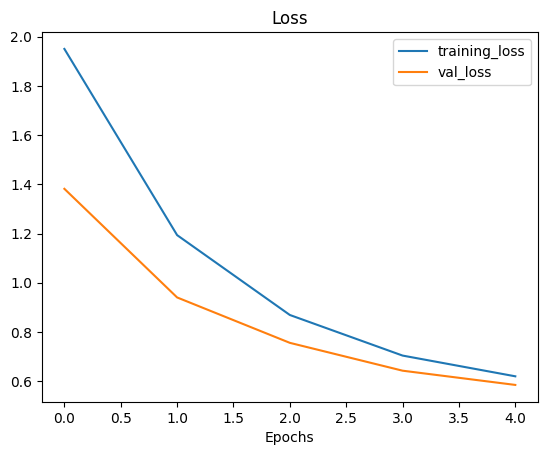

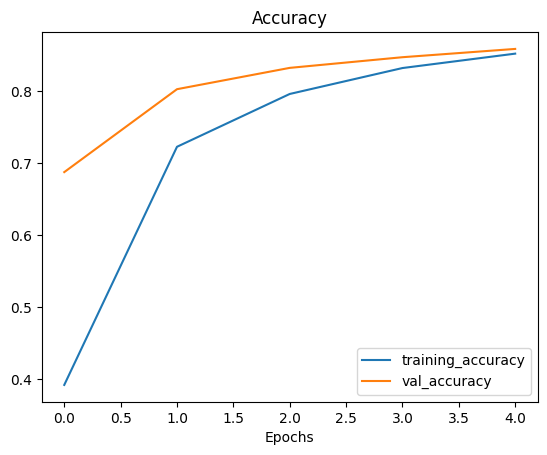

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

In [ ]:
import random
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


#

In [ ]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [ ]:
#get the data 1 percent dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2023-08-27 12:40:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  39.2MB/s    in 3.3s    

2023-08-27 12:40:55 (39.2 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# add data augmentation right into the model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Running a series of transfer learning experiments


We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
1. **Model 1**: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. **Model 2**: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
3. **Model 3**: Fine-tune the **Model 2** checkpoint on 10% of the training data with data augmentation.
4. **Model 4**: Fine-tune the **Model 2** checkpoint on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the **same test dataset**, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetV2B0` model within the `tf.keras.applications.efficientnet_v2` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [ ]:
data_augmentation= tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    # preprocessing.Rescaling(1/255.)
 ],name="data_augmentation")


#Adding Data Augmentation into the model
To add data augmentation into our model we can use yh e layer inside

* `tf.keras.layers.experimental.preprocessing.`

We can see the benefits of doing this within the tensorflow data augmentation
documentation

Off the top oour of heads, after reading the docs the benefits of using data augnentation inside the model are:
* preprocessing of images happens on the gpu
* image data augmentaion only happens during training , so we can still export our whole model and use it elsewhere

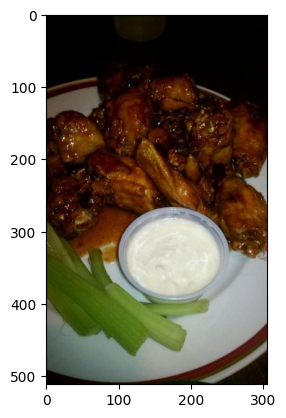

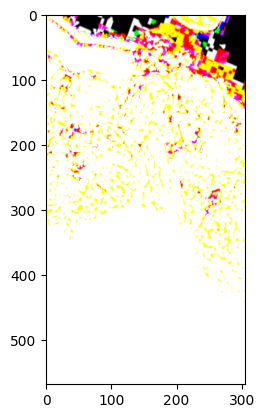

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread("/content/10_food_classes_1_percent/train/chicken_wings/1022867.jpg")
plt.imshow(img)
plt.figure()
plt.imshow(data_augmentation(img,training="True"))

In [ ]:
import random
import os
def random_image(directory="/content/10_food_classes_1_percent/train",target_class="fried_rice"):
  path=directory+"/"+target_class
  chosen_image=random.choice(os.listdir(path))
  path_to_image=path+"/"+chosen_image

  #Augmemting_data
  data_augmentation= tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    # preprocessing.Rescaling(1/255.)
 ],name="data_augmentation")




  img=plt.imread(path_to_image)
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.title("Original Image")

  plt.subplot(1,2,2)

  aug_image=data_augmentation(img/255.)
  plt.imshow(aug_image)
  plt.title("Augmented_image")



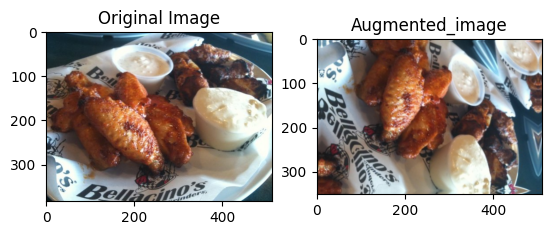

In [ ]:
random_image(target_class="chicken_wings")

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data_10_percent,
                    validation_steps=int(0.25* len(test_data_10_percent)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230827-124101
Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.5007 - accuracy: 0.1000 - val_loss: 2.2954 - val_accuracy: 0.1447
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.2862 - accuracy: 0.1286 - val_loss: 2.1726 - val_accuracy: 0.2105
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 2.0877 - accuracy: 0.3286 - val_loss: 2.0597 - val_accuracy: 0.2895
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.9312 - accuracy: 0.4286 - val_loss: 1.9673 - val_accuracy: 0.3553
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.7996 - accuracy: 0.5143 - val_loss: 1.8844 - val_accuracy: 0.3947




Wow!

How cool is that? Using only 7 training images per class, using transfer learning our model was able to get ~45%+ accuracy on the validation set.

This result is pretty amazing since the original Food-101 paper achieved 50.67% accuracy with all the data, namely, 750 training images per class (note: this metric was across 101 classes, not 10, we'll get to 101 classes soon).

If we check out a summary of our model, we should see the data augmentation layer just after the input layer.


In [ ]:
result_10_percent_data_aug=model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 74ms/step - loss: 1.8736 - accuracy: 0.4108




There it is. We've now got data augmentation built right into the our model. This means if we saved it and reloaded it somewhere else, the data augmentation layers would come with it.

The important thing to remember is data augmentation only runs during training. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

To see this in action, let's evaluate our model on the test data.


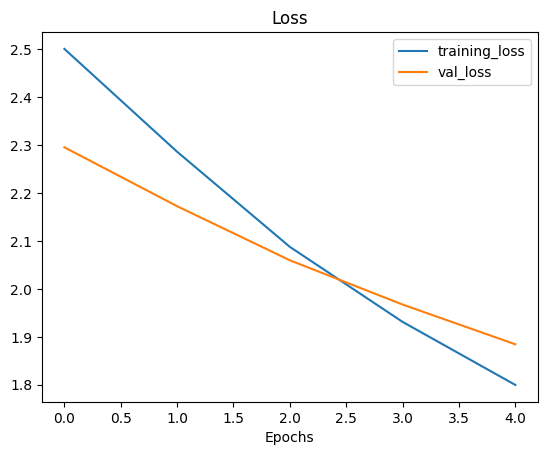

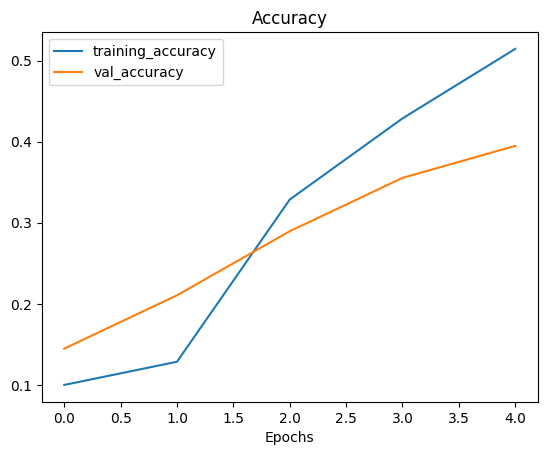

In [ ]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

Alright, we've tested 1% of the training data with data augmentation, how about we try 10% of the data with data augmentation?

But wait...

> 🤔 **Question:** How do you know what experiments to run?

Great question.

The truth here is you often won't. Machine learning is still a very experimental practice. It's only after trying a fair few things that you'll start to develop an intuition of what to try.

My advice is to follow your curiosity as tenaciously as possible. If you feel like you want to try something, write the code for it and run it. See how it goes. The worst thing that'll happen is you'll figure out what doesn't work, the most valuable kind of knowledge.

From a practical standpoint, as we've talked about before, you'll want to reduce the amount of time between your initial experiments as much as possible. In other words, run a plethora of smaller experiments, using less data and less training iterations before you find something promising and then scale it up.

In the theme of scale, let's scale our 1% training data augmentation experiment up to 10% training data augmentation. That sentence doesn't really make sense but you get what I mean.

We're going to run through the exact same steps as the previous model, the only difference being using 10% of the training data instead of 1%.

In [ ]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Awesome!

We've got 10x more images to work with, 75 per class instead of 7 per class.

Let's build a model with data augmentation built in. We could reuse the data augmentation Sequential model we created before but we'll recreate it to practice.

In [ ]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

## OLD
# # Build data augmentation layer
# data_augmentation = Sequential([
#   preprocessing.RandomFlip('horizontal'),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomRotation(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

To save time for later (when we want to perform multiple experiments with `model_2`), let's put the code above into a function we can resuse.

In [ ]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

### Creating a ModelCheckpoint callback

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do.

But first, let's create a `ModelCheckpoint` callback. To do so, we have to specifcy a directory we'd like to save to.

In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

> 🤔 **Question:** What's the difference between saving the entire model (SavedModel format) and saving the weights only?

The [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable `initial_epochs` and set it to 5 to use later.

We'll also add in our `checkpoint_callback` in our list of `callbacks`.

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug  = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230827-124151
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0472 - accuracy: 0.3227
Epoch 1: val_loss improved from inf to 1.53140, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 30s 904ms/step - loss: 2.0472 - accuracy: 0.3227 - val_loss: 1.5314 - val_accuracy: 0.6283
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4414 - accuracy: 0.6253
Epoch 2: val_loss improved from 1.53140 to 1.09175, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 716ms/step - loss: 1.4414 - accuracy: 0.6253 - val_loss: 1.0917 - val_accuracy: 0.7303
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1303 - accuracy: 0.7213
Epoch 3: val_loss improved from 1.09175 to 0.88818, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=

Would you look at that! Looks like our `ModelCheckpoint` callback worked and our model saved its weights every epoch without too much overhead (saving the whole model takes longer than just the weights).

Let's evaluate our model and check its loss curves.

In [ ]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 66ms/step - loss: 0.6733 - accuracy: 0.8212


[0.6732573509216309, 0.8212000131607056]

Looking at these, our model's performance with 10% of the data and data augmentation isn't as good as the model with 10% of the data without data augmentation (see `model_0` results above), however the curves are trending in the right direction, meaning if we decided to train for longer, its metrics would likely improve.

Since we checkpointed (is that a word?) our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluting it on the test data.

To load saved model weights you can use the the [`load_weights()`](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options) method, passing it the path where your saved weights are stored.

Now let's compare the results of our previously trained model and the loaded model. These results should very close if not exactly the same. The reason for minor differences comes down to the precision level of numbers calculated.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 66ms/step - loss: 0.6733 - accuracy: 0.8212


In [ ]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

True

If the above cell doesn't output `True`, it's because the numbers are close but not the *exact* same (due to how computers store numbers with degrees of precision).

However, they should be *very* close...

In [ ]:
import numpy as np
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


In [ ]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
loaded_weights_model_results=model_2.load_weights(checkpoint_path)

# np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
for layer_number, layer in enumerate(model_2.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.engine.input_layer.InputLayer object at 0x7bc167151060> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.engine.sequential.Sequential object at 0x7bc1673c37c0> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.engine.functional.Functional object at 0x7bc157657be0> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7bc167196080> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.layers.core.dense.Dense object at 0x7bc1576daec0> | Trainable? True


In [ ]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

Alright, it looks like all of the layers in the `efficientnetv2-b0` layer are frozen. We can confirm this using the `trainable_variables` attribute.

> **Note:** The layers of `base_model` (our `efficientnetv2-b0` feature extractor) of `model_2` is accessible by referencing `model_2.layers[2]`.

In [ ]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [ ]:
# How many layers are trainable in our model_2_base_model?
print(len(model_2_base_model.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)

0


In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

Beautiful. This is exactly what we're after.

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

> 🤔 **Question:** How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every layer in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.

> 📖 **Resource:** The [ULMFiT (Universal Language Model Fine-tuning for Text Classification) paper](https://arxiv.org/abs/1801.06146) has a great series of experiments on fine-tuning models.

To begin fine-tuning, we'll unfreeze the entire `model_2_base_model` by setting its `trainable` attribute to `True`.

Then we'll refreeze every layer in `model_2_base_model` except for the last 10 by looping through them and setting their `trainable` attribute to `False`.

Finally, we'll recompile the whole model.

In [ ]:
# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230827-124607
Epoch 5/10
24/24 [==============================] - 29s 711ms/step - loss: 0.7050 - accuracy: 0.8040 - val_loss: 0.5120 - val_accuracy: 0.8388
Epoch 6/10
24/24 [==============================] - 14s 557ms/step - loss: 0.6086 - accuracy: 0.8053 - val_loss: 0.5098 - val_accuracy: 0.8306
Epoch 7/10
24/24 [==============================] - 14s 561ms/step - loss: 0.5424 - accuracy: 0.8307 - val_loss: 0.5059 - val_accuracy: 0.8322
Epoch 8/10
24/24 [==============================] - 11s 461ms/step - loss: 0.4993 - accuracy: 0.8440 - val_loss: 0.4495 - val_accuracy: 0.8388
Epoch 9/10
24/24 [==============================] - 14s 573ms/step - loss: 0.4719 - accuracy: 0.8520 - val_loss: 0.4601 - val_accuracy: 0.8503
Epoch 10/10
24/24 [==============================] - 13s 511ms/step - loss: 0.4602 - accuracy: 0.8627 - val_loss: 0.4985 - val_accuracy: 0.8306


In [ ]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 68ms/step - loss: 0.4524 - accuracy: 0.8432


In [ ]:
# Remember, the results from evaluating the model might be slightly different to the outputs from training since during training we only evaluate on 25% of the test data.

# Alright, we need a way to evaluate our model's performance before and after fine-tuning. How about we write a function to compare the before and after?

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3226666748523712, 0.625333309173584, 0.7213333249092102, 0.7706666588783264, 0.7866666913032532, 0.8040000200271606, 0.8053333163261414, 0.8306666612625122, 0.843999981880188, 0.8519999980926514, 0.862666666507721]


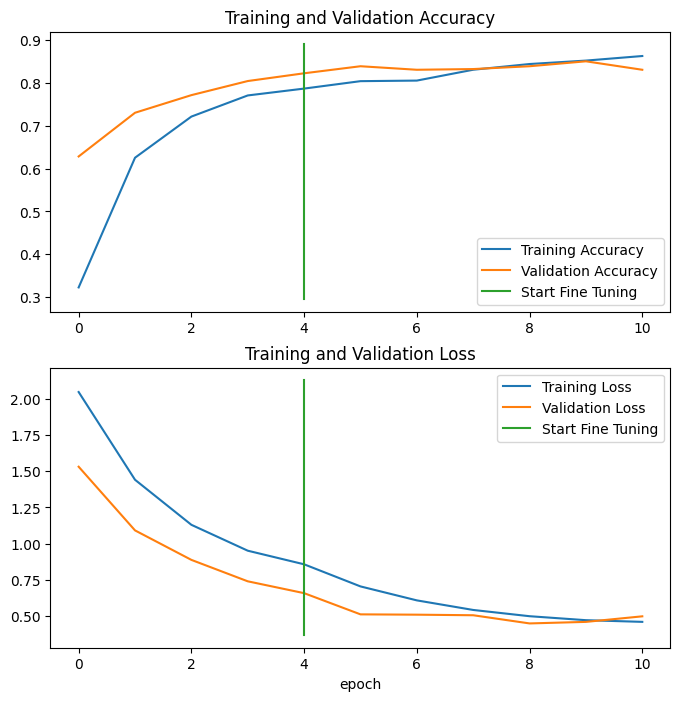

In [ ]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 3: Fine-tuning an existing model on 10% of the data

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)
*High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.*

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (`EfficientNetV2B0`) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras' guide on Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/).

We've verified our loaded model's performance, let's check out its layers.

#Model 3 : Finetuning an existing model on 10% of the data
**Note:** Fine tuning ususlly works best after training a feature extraction model for a few wpochs with a large amount of custom data

In [ ]:
# lyaers in out loaded modle?
#  mdoel 3 is fine tunes model of model2

model_2.layers

In [ ]:
#are these layers trainable?
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7bc167151060> True
<keras.engine.sequential.Sequential object at 0x7bc1673c37c0> True
<keras.engine.functional.Functional object at 0x7bc157657be0> True
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7bc167196080> True
<keras.layers.core.dense.Dense object at 0x7bc1576daec0> True


In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name,layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
#how many trainable models are in out model

print(len(
    model_2.layers[2].trainable_variables))

10


In [ ]:
for layer in model_2.layers:
  print(layer.name)

input_layer
data_augmentation
efficientnetv2-b0
global_average_pooling_layer
output_layer


In [ ]:
base_model=model_2.layers[2]

In [ ]:
for layer in base_model.layers:
  print(layer.name,layer.trainable)

input_4 False
rescaling_3 False
normalization_3 False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block3a_expand_conv False
block3a_expand_bn False
block3a_expand_activation False
block3a_project_conv False
block3a_project_bn False
block3b_expand_conv False
block3b_expand_bn False
block3b_expand_activation False
block3b_project_conv False
block3b_project_bn False
block3b_drop False
block3b_add False
block4a_expand_conv False
block4a_expand_bn False
block4a_expand_activation False
block4a_dwconv2 False
block4a_bn False
block4a_activation False
block4a_se_squeeze False
block4a_se_reshape False
blo

In [ ]:

#To begin fine tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable=True

#Freeze all layers except last 10;
for layer in base_model.layers[:-10]:
  layer.trainable=False

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)



0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
#Recompile (we have to recompile our model every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

In [ ]:
# fine tune our model for another 5 epochs
fine_tune_epochs=initial_epochs+5 #10
history_fine_10_percent_data_aug=model_2.fit(train_data_10_percent,
                                             epochs=fine_tune_epochs,#10,
                                             validation_data=test_data,
                                             validation_steps=int(0.25*len(test_data)),
                                             initial_epoch=history_10_percent_data_aug.epoch[-1], # start trainaing from the previous last epochs
                                             callbacks=[create_tensorboard_callback(dir_name="tarnsfer_learning",experiment_name="10_percent_fine_tune_last_epochs")]
                                              )



Saving TensorBoard log files to: tarnsfer_learning/10_percent_fine_tune_last_epochs/20230827-124750
Epoch 5/10
24/24 [==============================] - 24s 588ms/step - loss: 0.6224 - accuracy: 0.7853 - val_loss: 0.4391 - val_accuracy: 0.8586
Epoch 6/10
24/24 [==============================] - 13s 487ms/step - loss: 0.3850 - accuracy: 0.8707 - val_loss: 0.5294 - val_accuracy: 0.8240
Epoch 7/10
24/24 [==============================] - 12s 495ms/step - loss: 0.2863 - accuracy: 0.9133 - val_loss: 0.4590 - val_accuracy: 0.8454
Epoch 8/10
24/24 [==============================] - 11s 442ms/step - loss: 0.2272 - accuracy: 0.9280 - val_loss: 0.4862 - val_accuracy: 0.8503
Epoch 9/10
24/24 [==============================] - 11s 419ms/step - loss: 0.2139 - accuracy: 0.9320 - val_loss: 0.4541 - val_accuracy: 0.8618
Epoch 10/10
24/24 [==============================] - 12s 466ms/step - loss: 0.1895 - accuracy: 0.9480 - val_loss: 0.4649 - val_accuracy: 0.8766


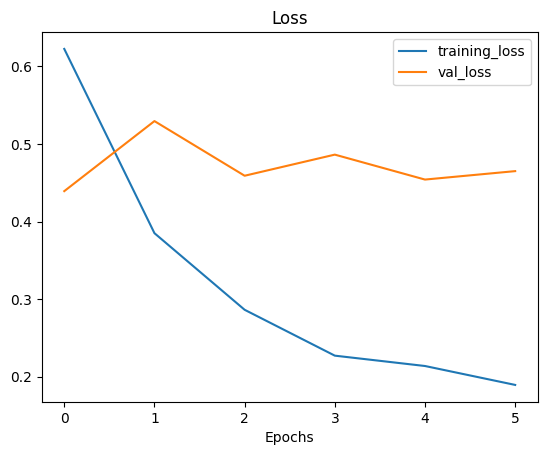

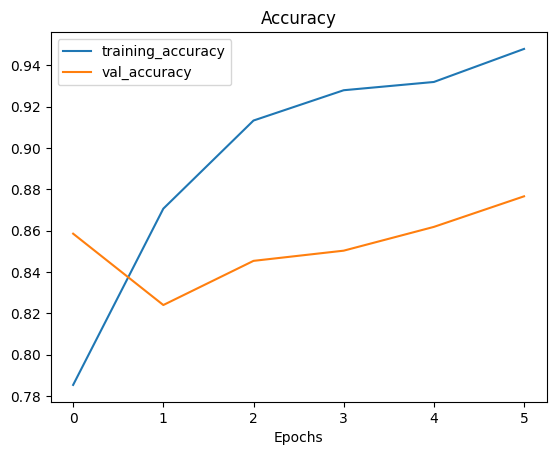

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
#lets create a function to

we want something to compare one series running fit with another, i.e compare before and after

In [ ]:
def compare_history(original_history,new_history,initial_epochs=5):

  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  total_acc = acc+ new_history.history["accuracy"]
  total_loss = loss+new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  plt.figure(figsize=(8,8))

  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Training_Accuracy")
  plt.plot(total_val_acc,label="Validation_Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend()

  plt.subplot(2,1,2)
  plt.plot(total_loss,label="Training_loss")
  plt.plot(total_val_loss,label="Validation_loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")

  plt.legend()


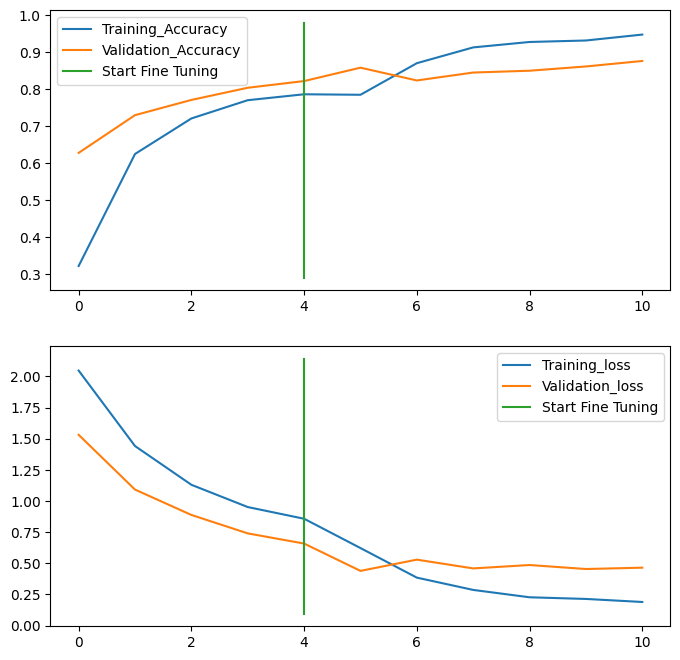

In [ ]:
compare_history(history_10_percent_data_aug,history_fine_10_percent_data_aug)

#Model4

In [ ]:
# model4  download data for it
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-08-27 12:49:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  91.2MB/s    in 5.9s    

2023-08-27 12:49:19 (83.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
unzip_data("10_food_classes_all_data.zip")

In [ ]:
# Setup training and test dir

train_dir_all_data="10_food_classes_all_data/train"
test_dir="10_food_classes_all_data/test"

In [ ]:
#How many functions are we eorking with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [ ]:
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_classes_full=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_all_data,
                                                                               image_size=IMG_SIZE,
                                                                               label_mode="categorical",
                                                                               )
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                batch_size=BATCH_SIZE,
                                                label_mode="categorical",
                                                image_size=IMG_SIZE
                                                )


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


the test data loaded in is same as what we have been using in experiments. All experiments have used the same dataset

to train a fine tuning model we need to revert model_2 back to its feature extraction weights.

In [ ]:
# load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data was fine-tuned from
model_2.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 0.4481 - accuracy: 0.8636


[0.4481316804885864, 0.8636000156402588]

In [ ]:
results_fine_tune_10_percent

[0.4523667097091675, 0.8432000279426575]

To keep our experiments clean, we'll load a create a new instance of `model_2` using our `create_base_model()` function.

More specifically, we're trying to measure:
* **Experiment 3 (previous one)** - `model_2` with 10 layers fine-tuned for 5 more epochs on 10% of the data.
* **Experiment 4 (this one)** - `model_2` with layers fined-tuned for 5 more epochs on 100% on the data.

Importantly, both experiments should use the same test data (to keep evaluation the same).

And they should also start from the same checkpoint (`model_2` feature extractor trained for 5 epochs on 10% of the data).

Let's first create new instance of `model_2`.

In [ ]:
model_2= create_base_model(learning_rate=0.0001)

In [ ]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [ ]:
print(len(model_2.trainable_variables))

2


In [ ]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 10s 83ms/step - loss: 0.6733 - accuracy: 0.8212


[0.6732573509216309, 0.8212000131607056]

In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

Now let's make sure the right layers are trainable (we only want the last 10 to be trainable).

> **Note:** You could experiment which number of layers should be trainable here. Generally, the more data you have, the more layers that can be fine-tuned.

In [ ]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

Looking good! The last 10 layers are trainable (unfrozen).

We've got one more step to do before we can begin fine-tuning.

Do you remember what it is?

I'll give you a hint. We just reloaded the weights to our model and what do we need to do every time we make a change to our models?

Recompile them!

This will be just as before.

In [ ]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230827-124959
Epoch 5/10
235/235 [==============================] - 88s 331ms/step - loss: 0.7153 - accuracy: 0.7719 - val_loss: 0.3766 - val_accuracy: 0.8684
Epoch 6/10
235/235 [==============================] - 64s 271ms/step - loss: 0.6024 - accuracy: 0.8067 - val_loss: 0.3475 - val_accuracy: 0.8882
Epoch 7/10
235/235 [==============================] - 59s 249ms/step - loss: 0.5429 - accuracy: 0.8253 - val_loss: 0.3012 - val_accuracy: 0.9030
Epoch 8/10
235/235 [==============================] - 52s 220ms/step - loss: 0.5050 - accuracy: 0.8345 - val_loss: 0.2962 - val_accuracy: 0.9062
Epoch 9/10
235/235 [==============================] - 48s 204ms/step - loss: 0.4789 - accuracy: 0.8437 - val_loss: 0.3026 - val_accuracy: 0.9095
Epoch 10/10
235/235 [==============================] - 48s 205ms/step - loss: 0.4518 - accuracy: 0.8525 - val_loss: 0.2685 - val_accuracy: 0.9161


In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 68ms/step - loss: 0.2705 - accuracy: 0.9116


[0.270471453666687, 0.9115999937057495]

In [ ]:
results_fine_tune_10_percent

[0.4523667097091675, 0.8432000279426575]

5
11
[0.3226666748523712, 0.625333309173584, 0.7213333249092102, 0.7706666588783264, 0.7866666913032532, 0.7718666791915894, 0.8066666722297668, 0.8253333568572998, 0.8345333337783813, 0.8437333106994629, 0.8525333404541016]


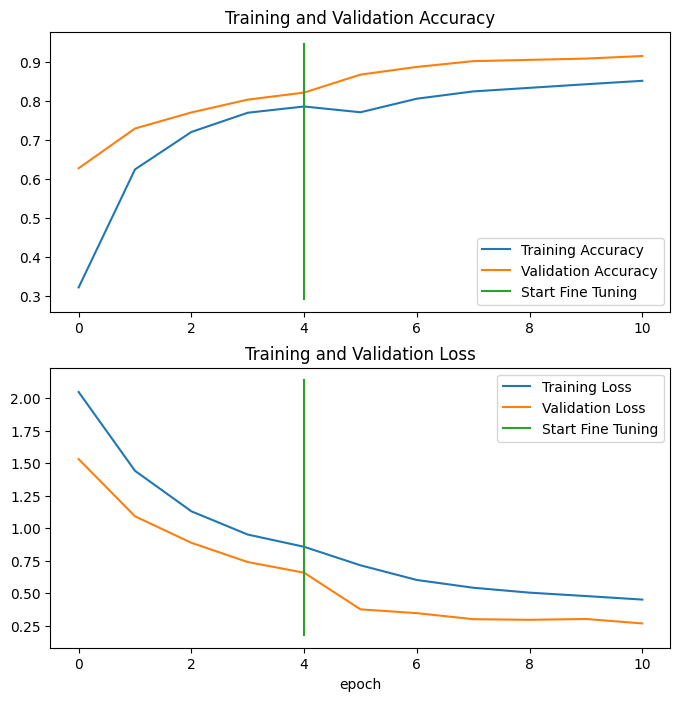

In [ ]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

Right now our experimental results are scattered all throughout our notebook. If we want to share them with someone, they'd be getting a bunch of different graphs and metrics... not a fun time.

But guess what?

Thanks to the TensorBoard callback we made with our helper function `create_tensorflow_callback()`, we've been tracking our modelling experiments the whole time.

How about we upload them to TensorBoard.dev and check them out?

We can do with the `tensorboard dev upload` command and passing it the directory where our experiments have been logged.

> 🔑 **Note:** Remember, whatever you upload to TensorBoard.dev becomes public. If there are training logs you don't want to share, don't upload them.